# ENS Challenge Data - Predilex
###  NLP applied to judicial decisions parsing 
#### Mohamed Bejaoui & Fei Wu & Carlos Augusto Figueiredo Freire De Carvalho 

Predilex has “jurisprudence” data as text files and they want to build an algorithm to automate the extraction of the following relevant information:
<ul>
    <li>the sex of the victim</li>
    <li>the date of the accident</li>
    <li>date of the consolidation</li>

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import pandas as pd
import re
import numpy as np
from typing import List, Tuple

from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import FeatureUnion
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from utils import clean_text, apply_cv, perform_grid_search, clean2, remove_ambigous_sentences, find_opti_thresh

## Data import and first look

In [117]:
#x_train data
x_tr_df = pd.read_csv('./train_folder/x_train_ids.csv', index_col=0)
tr_dir = "./train_folder/txt_files/"
tr_files = x_tr_df['filename'].values
tr_texts = []
for tr_file in tr_files:
    f = open(os.path.join(tr_dir, tr_file), "r")
    tr_texts.append(f.read().replace('\xa0', ' ').replace('\n', ' '))

#x_test data
x_te_df = pd.read_csv('./test_folder/x_test_ids.csv', index_col=0)
te_dir = "./test_folder/txt_files/"
te_files = x_te_df['filename'].values
te_texts = []
for te_file in te_files:
    f = open(os.path.join(te_dir, te_file), "r")
    te_texts.append(f.read().replace('\xa0', ' ').replace('\n', ' '))


#y_train data
y_tr_df = pd.read_csv('./Y_train_predilex.csv', index_col=0)

This is how a training example looks like

In [118]:
i = 0
print('File :', x_tr_df.iloc[i]['filename'])
print('Text (200 first char):', tr_texts[i][:200])
print('Output : ')
print(y_tr_df.iloc[i])

File : Agen_100515.txt
Text (200 first char): Le : 12/11/2019     Cour d’appel d’Agen    chambre sociale    Audience publique du 30 avril 2002    N° de RG: 01/00515          REPUBLIQUE FRANCAISE   AU NOM DU PEUPLE FRANCAIS   ARRET DU 30 AVRIL 200
Output : 
sexe                       homme
date_accident         1991-04-09
date_consolidation          n.c.
Name: 0, dtype: object


In [119]:
print(f"Number of training samples: {len(tr_texts)}")
print(f"Number of test samples: {len(te_texts)}")

Number of training samples: 770
Number of test samples: 257


We can have a look at a "jurisprudence" text

In [120]:
tr_texts[0]

'Le : 12/11/2019     Cour d’appel d’Agen    chambre sociale    Audience publique du 30 avril 2002    N° de RG: 01/00515          REPUBLIQUE FRANCAISE   AU NOM DU PEUPLE FRANCAIS   ARRET DU 30 AVRIL 2002 ----------------------- 01/00515 ----------------------- Yvon X... Annie X... C/ GROUPE AZUR ASSURANCES IARD CAISSE PRIMAIRE D’ASSURANCE MALADIE DE LOT ET GARONNE Yannick GUGUEN ès qualités de mandataire liquidateur à la liquidation judiciaire de la société des transports MOREL ----------------------- ARRET N° COUR D’APPEL D’AGEN CHAMBRE SOCIALE Prononcé à l’audience publique du trente Avril deux mille deux par Madame LATRABE, Conseiller, La COUR d’APPEL D’AGEN, CHAMBRE SOCIALE, dans l’affaire ENTRE : Monsieur Yvon X... né le 30 Septembre 1955 à TONNEINS (47) Y... du Laurier 47300 BIAS Rep/assistant : Me Pascale LUGUET (avocat au barreau d’AGEN) Madame Annie X... Y... du Laurier 47300 BIAS Rep/assistant : Me Pascale LUGUET (avocat au barreau d’AGEN) APPELANTS d’un jugement du Tribunal d

## Gender prediction

How many training examples with missing gender value?

In [134]:
len(y_tr_df[y_tr_df['sexe'] == 'n.c.'])

0

In [135]:
# drop rows with unknow gender in training set
gender_na_idx = y_tr_df[y_tr_df['sexe'] == 'n.c.'].index
y_tr_df = y_tr_df[y_tr_df['sexe'] != 'n.c.']
y_tr_df.reset_index(inplace=True, drop=True)

tr_texts = [tr_texts[i] for i in range(len(tr_texts)) if i not in gender_na_idx]

Now, we vectorize each training text and construct x_train and y_train

In [152]:
tfidf_vec = FeatureUnion([
    ('tfidf_ngram1', TfidfVectorizer(ngram_range=(1, 1), max_features=75)),
    ('tfidf_ngram2', TfidfVectorizer(ngram_range=(1, 2), max_features=50))
])
x_train_gender = tfidf_vec.fit_transform([clean_text(text) for text in tr_texts])
y_train_gender = y_tr_df['sexe'].map({'homme': 1, 'femme': 0}).values

We can check if the data is unbalanced or not for the gender classification task

In [153]:
c_val, c_count = np.unique(y_train_gender, return_counts=True)
for i, c in enumerate(c_val):
    print(f"Number of samples for class {c}: {c_count[i]}")

Number of samples for class 0: 206
Number of samples for class 1: 559


Now, let's fit an xgboost classifier. First we will look for the optimal hyperparameters using a grid search

In [154]:
random_state = 42

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [.01, .1],
    'subsample': [.7, .9, 1],
    'colsample_bytree': [.7, .9, 1],
}
xgb_cls = XGBClassifier(random_state=random_state)
xgb_cls = perform_grid_search(xgb_cls, param_grid, x_train_gender, y_train_gender, metric='accuracy')

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  3.6min finished


The best hyperparameters from Grid Seach are: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.9}


We can test the performance of the classifier using a 3-fold cross validation

In [240]:
apply_cv(xgb_cls, x_train_gender, y_train_gender, metric='accuracy', cv=3)

CV accuracy: 91.11%


In [22]:
xgb_cls.fit(x_train_gender, y_train_gender)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

Now, let's predict the gender of the test dataset and save the result into a numpy array.

In [23]:
x_test_gender = tfidf_vec.transform([clean_text(text) for text in te_texts])
y_test_gender = xgb_cls.predict(x_test_gender)
y_test_gender = list(map(lambda x: 'homme' if x==1 else 'femme', y_test_gender))

In [24]:
np.save('results/gender.npy', y_test_gender)

## Accident date prediction

First, we need to define a couple of useful variables

In [25]:
# REGEX PATTERNS

pattern1 = r"\d{1,2} \w{3,9} \d{2,4}"
pattern2 = r"1° \w{3,9} \d{2,4}"
pattern3 = r"1er \w{3,9} \d{2,4}"
pattern4 = r"\d{1,2}/\d{1,2}/\d{2,4}"
pattern5 = r"\d{1,2} / \d{1,2} / \d{2,4}"
pattern6 = r"\d{1,2}/ \d{1,2}/ \d{2,4}"


pattern1_bis = r"(\d{1,2}) (\w{3,9}) (\d{2,4})"
pattern2_bis = r"(1°) (\w{3,9}) (\d{2,4})"
pattern3_bis = r"(1er) (\w{3,9}) (\d{2,4})"
pattern4_bis = r"(\d{1,2})/(\d{1,2})/(\d{2,4})"
pattern5_bis = r"(\d{1,2}) / (\d{1,2}) / (\d{2,4})"
pattern6_bis = r"(\d{1,2})/ (\d{1,2})/ (\d{2,4})"

patterns = [pattern1, pattern2, pattern3, pattern4, pattern5, pattern6] 
patterns_bis = [pattern1_bis, pattern2_bis, pattern3_bis, pattern4_bis, pattern5_bis, pattern6_bis] 
    
months_str_to_int = dict(janvier='01', fevrier='02', mars='03', avril='04', mai='05', juin='06',
                         juillet='07', aout='08', septembre='09', octobre='10', novembre='11',
                         decembre='12')

def format_date(day:str, month:str, year:str):
    if len(day) == 1:
        day = '0' + day
    elif not day.isnumeric():
        day = '01'
    if not month.isnumeric():
        month = months_str_to_int[month]
    elif len(month) == 1:
        month = '0' + month
    if len(year) == 2:
        if int(year) < 30: year = '20' + year
        else: year = '19' + year
    return day, month, year

Now, for each training text, we extract all sentences containing one or more dates.

In [92]:
import nltk
from tqdm import tqdm
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/mohamed/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mohamed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [93]:
stemmer = SnowballStemmer('french')
lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('french'))

In [94]:
leftover = []
x_train = []
y_train = []

for i in tqdm(range(len(tr_texts))):
    text = tr_texts[i]
    if y_tr_df.iloc[i]['date_accident'] != 'n.c.':
        index = []
        dates = []
        for k, pattern in enumerate(patterns):
            index.extend(re.finditer(pattern, text))
            dates.extend(re.findall(patterns_bis[k], text))

        zipped = sorted(list(zip(index,dates)), key = lambda x: x[0].start())
        for j in range((len(index))):
            index[j] = zipped[j][0]
            dates[j] = zipped[j][1]
        start_index = index[2].end()
        index = index[3:]
        dates = dates[3:]

        window = 100
        sequences = []
        for k, ind in enumerate(index):
            day, month, year = dates[k][0], dates[k][1], dates[k][2]
            month = month.lower().replace('é', 'e').replace('û', 'u')
            if (month in months_str_to_int) or (month in months_str_to_int.values()):
                day, month, year = format_date(day, month, year)
                date = f"{year}-{month}-{day}"

                if date == y_tr_df.iloc[i]['date_accident']: y_train.append(1)
                else: y_train.append(0)

                match1 = re.match(r"[^\.]*(\.)", text[ind.end(): ind.end() + window])        
                match2 = re.match(r"[^\.]*(\.)", text[ind.start() - window : ind.start()][::-1])

                if match2: start = len(text[:ind.start()]) - match2.end() + 1
                else: start = ind.start() - window
                if match1: end = len(text[:ind.end()]) + match1.end()
                else: end = ind.end() + window

                chunk = text[start:end]
                if start == ind.start() - window: chunk = re.sub(r"^[^\s]*\s*", "", chunk)
                if end == ind.end() + window: chunk = re.sub(r"\s*[^\s]*$", "", chunk)

                chunk = clean2(chunk, lemmatizer, stemmer, stop_words = stop_words)
                x_train.append(chunk)
                
                #if (start, end) in sequences and y_train[-1] == 1: print('text ' + str(i), (start,end))
                sequences.append((start,end))
                

        final = []
        i = 0
        while i != len(sequences):
            start = sequences[i][0]
            while i+1 != len(sequences) and sequences[i+1][0] == start:
                i += 1
            end = sequences[i][1]
            i += 1
            final.append((start,end))

        sequences = [(start_index, final[0][0])]
        for i in range(len(final)-1):
            sequences.append((final[i][1], final[i+1][0]))
        sequences.append((final[-1][1],-1))

        lf = ''
        for s in sequences:
            if s[1] == -1 or s[1] - s[0] >= 20: 
                morceau = re.sub(r"^[^\s]*\s*", "", text[s[0]:s[1]])
                if s[1] != -1: morceau = re.sub(r"\s*[^\s]*$", "", morceau)
                lf = lf + morceau + '. '
        lf = lf[:-1]
        leftover.append(lf)

    else:
        index = []
        for k, pattern in enumerate(patterns):
            index.extend(re.finditer(pattern, text))

        index = sorted(index, key = lambda x: x.start())
        start_index = index[2].end()
        leftover.append(text[start_index:].strip())

100%|██████████| 765/765 [00:39<00:00, 19.20it/s]


In [95]:
df = pd.DataFrame({'text': x_train, 'accident': y_train})
df.drop_duplicates(subset=['text', 'accident'], inplace=True)
remove_ambigous_sentences(df, 'accident');
df.to_csv('data.csv')

In [96]:
x_train = df['text'].to_numpy()
y_train = df['accident'].to_numpy()

Now, let's train an xgboost

In [97]:
TF_IDF = FeatureUnion([
    ('tfidf_ngram1', TfidfVectorizer(ngram_range=(1, 1), max_features=1000, norm='l2', sublinear_tf=True, min_df=25)),
    ('tfidf_ngram2', TfidfVectorizer(ngram_range=(1, 2), max_features=750, norm='l2', sublinear_tf=True, min_df=25))
])
x_train = TF_IDF.fit_transform(x_train)

In [98]:
classifier = XGBClassifier(max_depth = 5,
                           n_estimators = 500,
                           learning_rate = 0.1,
                           subsample = 0.7,
                           colsample_bytree = 0.9,
                           random_state = 42)

In [99]:
classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

We can measure the performance of the predictor using cross validation on f1 and auc metrics

In [36]:
print(apply_cv(classifier, x_train, y_train, 'roc_auc'))
print(apply_cv(classifier, x_train, y_train, 'f1'))

CV roc_auc: 91.11%
None
CV f1: 56.36%
None


Now, we will look for the optimal threshold under which we consider the accident date of a text as unknown(n.c.)

In [100]:
proba = classifier.predict_proba(x_train)

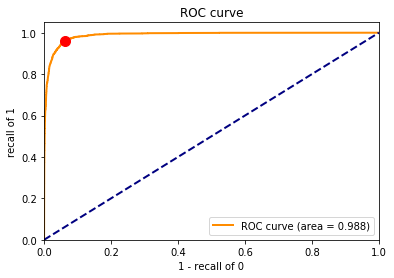

optimal threshold is 0.16364260017871857


In [101]:
t, _ = find_opti_thresh(y_train, proba[:,1])

Now, we can do the predictions on the test set

In [102]:
candidates = []
sentence_dates = []
for i in tqdm(range(len(te_texts))):
    text = te_texts[i]
    index = []
    dates = []
    for k, pattern in enumerate(patterns):
        index.extend(re.finditer(pattern, text))
        dates.extend(re.findall(patterns_bis[k], text))

    zipped = sorted(list(zip(index,dates)), key = lambda x: x[0].start())
    for j in range((len(index))):
        index[j] = zipped[j][0]
        dates[j] = zipped[j][1]
    index = index[3:]
    dates = dates[3:]
    
    window = 100
    data = []
    s_d = []
    for k, ind in enumerate(index):
        day, month, year = dates[k][0], dates[k][1], dates[k][2]
        month = month.lower().replace('é', 'e').replace('û', 'u')
        if month in months_str_to_int:
            day, month, year = format_date(day, month, year)
            date = f"{year}-{month}-{day}"
            s_d.append(date)

            match1 = re.match(r"[^\.]*(\.)", text[ind.end(): ind.end() + window])        
            match2 = re.match(r"[^\.]*(\.)", text[ind.start() - window : ind.start()][::-1])
            if match2: start = len(text[:ind.start()]) - match2.end() + 1
            else: start = ind.start() - window
            if match1: end = len(text[:ind.end()]) + match1.end()
            else: end = ind.end() + window

            chunk = text[start:end]
            if start == ind.start() - window: chunk = re.sub(r"^[^\s]*\s*", "", chunk)
            if end == ind.end() + window: chunk = re.sub(r"\s*[^\s]*$", "", chunk)

            #chunk = clean2(chunk, lemmatizer, stemmer, stop_words = stop_words)
            data.append(chunk)

    candidates.append(data)
    sentence_dates.append(s_d)

100%|██████████| 257/257 [00:01<00:00, 212.42it/s]


In [103]:
test_sentences_df = pd.DataFrame(columns=['te_idx', 'sentence', 'date'])
for i in tqdm(range(len(candidates))):
    test_sentences_df = pd.concat([test_sentences_df, 
                            pd.DataFrame({'te_idx': [i]*len(candidates[i]), 'sentence': candidates[i], 'date': sentence_dates[i]})],
                            ignore_index=True)

100%|██████████| 257/257 [00:00<00:00, 543.47it/s]


In [104]:
sentences_w_multip_dates_idx = list(test_sentences_df[test_sentences_df.duplicated('sentence')].index)
split_sentences_df = pd.DataFrame(columns=test_sentences_df.columns)

while sentences_w_multip_dates_idx != []:
    idx = sentences_w_multip_dates_idx[0]
    sentence = test_sentences_df.loc[idx, 'sentence']
    te_idx = test_sentences_df.loc[idx, 'te_idx']
    sentence_window = len(sentence) // 5
    sentences = {}

    for pattern_idx, pattern in enumerate(patterns):
        for date in re.finditer(pattern, sentence):
            current_date = date.group(0)
            reg_match = re.match(patterns_bis[pattern_idx], current_date)
            day, month, year = reg_match[1], reg_match[2], reg_match[3]
            try:
                day, month, year = format_date(day, month, year)
            except KeyError:
                continue            
            formated_date = f"{year}-{month}-{day}"
            sentences[formated_date] = sentence[max(date.start()-sentence_window, 0):date.end()+sentence_window]

    # drop current duplicated sentences from dataframe
    same_sentences_idx = test_sentences_df[(test_sentences_df['sentence']==sentence) & (test_sentences_df['te_idx']==te_idx)].index
    test_sentences_df.drop(same_sentences_idx, inplace=True)
    for idx in list(same_sentences_idx):
        if idx in sentences_w_multip_dates_idx:
            sentences_w_multip_dates_idx.remove(idx)
    split_sentences_df = pd.concat([split_sentences_df, 
            pd.DataFrame({'te_idx': [te_idx]*len(list(sentences.values())), 'sentence': list(sentences.values()), 'date': list(sentences.keys())})],
            ignore_index=True)

test_sentences_df = pd.concat([test_sentences_df, split_sentences_df], ignore_index=True)

In [105]:
candidates = []
sentence_dates = []

for i in tqdm(range(len(te_texts))):
    candidates.append(list(test_sentences_df.loc[test_sentences_df['te_idx']==i, 'sentence'].values))
    sentence_dates.append(list(test_sentences_df.loc[test_sentences_df['te_idx']==i, 'date'].values))

100%|██████████| 257/257 [00:00<00:00, 606.76it/s]


In [106]:
# clean texts
for i in tqdm(range(len(candidates))):
    candidates[i] = [clean2(candidate, lemmatizer, stemmer, stop_words = stop_words) for candidate in 
                        candidates[i]]

100%|██████████| 257/257 [00:07<00:00, 32.54it/s]


In [107]:
for i in range(len(candidates)):
    candidate = TF_IDF.transform(candidates[i])
    candidates[i] = candidate

In [108]:
preds = []
for i, candidate in enumerate(candidates):
    pred = np.argmax(classifier.predict_proba(candidate)[:,1])
    score = np.max(classifier.predict_proba(candidate)[:,1])
    if score < t: preds.append('n.c.')
    else:
        pred_date = sentence_dates[i][pred]
        preds.append(pred_date)

In [110]:
np.save('results/accident.npy', preds)

## Consolidation date prediction

In [49]:
stemmer = SnowballStemmer('french')
lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('french'))

In [50]:
leftover = []
x_train = []
y_train = []

for i in tqdm(range(len(tr_texts))):
    text = tr_texts[i]
    if y_tr_df.iloc[i]['date_consolidation'] != 'n.c.' and y_tr_df.iloc[i]['date_consolidation'] != 'n.a.':
        index = []
        dates = []
        for k, pattern in enumerate(patterns):
            index.extend(re.finditer(pattern, text))
            dates.extend(re.findall(patterns_bis[k], text))

        zipped = sorted(list(zip(index,dates)), key = lambda x: x[0].start())
        for j in range((len(index))):
            index[j] = zipped[j][0]
            dates[j] = zipped[j][1]
        start_index = index[2].end()
        index = index[3:]
        dates = dates[3:]

        window = 100
        sequences = []
        for k, ind in enumerate(index):
            day, month, year = dates[k][0], dates[k][1], dates[k][2]
            month = month.lower().replace('é', 'e').replace('û', 'u')
            if (month in months_str_to_int) or (month in months_str_to_int.values()):
                day, month, year = format_date(day, month, year)
                date = f"{year}-{month}-{day}"

                if date == y_tr_df.iloc[i]['date_consolidation']: y_train.append(1)
                else: y_train.append(0)

                match1 = re.match(r"[^\.]*(\.)", text[ind.end(): ind.end() + window])        
                match2 = re.match(r"[^\.]*(\.)", text[ind.start() - window : ind.start()][::-1])

                if match2: start = len(text[:ind.start()]) - match2.end() + 1
                else: start = ind.start() - window
                if match1: end = len(text[:ind.end()]) + match1.end()
                else: end = ind.end() + window

                chunk = text[start:end]
                if start == ind.start() - window: chunk = re.sub(r"^[^\s]*\s*", "", chunk)
                if end == ind.end() + window: chunk = re.sub(r"\s*[^\s]*$", "", chunk)

                chunk = clean2(chunk, lemmatizer, stemmer, stop_words = stop_words)
                x_train.append(chunk)
                
                #if (start, end) in sequences and y_train[-1] == 1: print('text ' + str(i), (start,end))
                sequences.append((start,end))
                

        final = []
        i = 0
        while i != len(sequences):
            start = sequences[i][0]
            while i+1 != len(sequences) and sequences[i+1][0] == start:
                i += 1
            end = sequences[i][1]
            i += 1
            final.append((start,end))

        sequences = [(start_index, final[0][0])]
        for i in range(len(final)-1):
            sequences.append((final[i][1], final[i+1][0]))
        sequences.append((final[-1][1],-1))

        lf = ''
        for s in sequences:
            if s[1] == -1 or s[1] - s[0] >= 20: 
                morceau = re.sub(r"^[^\s]*\s*", "", text[s[0]:s[1]])
                if s[1] != -1: morceau = re.sub(r"\s*[^\s]*$", "", morceau)
                lf = lf + morceau + '. '
        lf = lf[:-1]
        leftover.append(lf)

    else:
        index = []
        for k, pattern in enumerate(patterns):
            index.extend(re.finditer(pattern, text))

        index = sorted(index, key = lambda x: x.start())
        start_index = index[2].end()
        leftover.append(text[start_index:].strip())

100%|██████████| 765/765 [00:31<00:00, 23.98it/s]


In [51]:
df = pd.DataFrame({'text': x_train, 'consolidation': y_train})
df.drop_duplicates(subset=['text', 'consolidation'], inplace=True)
remove_ambigous_sentences(df, 'consolidation');
df.to_csv('data.csv')

In [53]:
x_train = df['text'].to_numpy()
y_train = df['consolidation'].to_numpy()

Here, in addition to classifing sentences containig a consolidation date or not, we will also build another classifier to tell where a consolidation date in applicable or not (n.a.) in a certain text

In [61]:
# construct na_x_train using a tfidfvec and na_y_train using label 1 for 'na' and label 0 for 'non na'
na_vectorizer = FeatureUnion([
    ('tfidf_ngram1', TfidfVectorizer(ngram_range=(1, 1), max_features=75, norm='l2', sublinear_tf=True, min_df=25)),
    ('tfidf_ngram2', TfidfVectorizer(ngram_range=(1, 2), max_features=25, norm='l2', sublinear_tf=True, min_df=25))
])
na_x_train = na_vectorizer.fit_transform([clean_text(text) for text in tr_texts])
na_y_train = np.zeros((len(tr_texts),))
na_y_train[y_tr_df['date_consolidation']=='n.a.'] = 1

In [62]:
# train an xgboost using gridsearch
random_state = 42

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [.01, .1],
    'subsample': [.7, .9, 1],
    'colsample_bytree': [.7, .9, 1],
}
xgb_cls_na = XGBClassifier(random_state=random_state)
xgb_cls_na = perform_grid_search(xgb_cls_na, param_grid, na_x_train, na_y_train, metric='accuracy')

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  2.0min finished


The best hyperparameters from Grid Seach are: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 7, 'subsample': 0.9}


In [63]:
apply_cv(xgb_cls_na, na_x_train, na_y_train, metric='accuracy', cv=3)

CV accuracy: 93.59%


In [64]:
xgb_cls_na.fit(na_x_train, na_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

Now, we move on to the vectorization of the extracted senteces database with the exact same methodology as the one for the accident date

In [65]:
TF_IDF = FeatureUnion([
    ('tfidf_ngram1', TfidfVectorizer(ngram_range=(1, 1), max_features=850, norm='l2', sublinear_tf=True, min_df=25)),
    ('tfidf_ngram2', TfidfVectorizer(ngram_range=(1, 2), max_features=850, norm='l2', sublinear_tf=True, min_df=25))
])
x_train = TF_IDF.fit_transform(x_train)

In [66]:
classifier = XGBClassifier(max_depth = 5,
                           n_estimators=300,
                           learning_rate = 0.1,
                           subsample = 0.7,
                           colsample_bytree = 0.9,
                           random_state = 42)

In [67]:
classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [70]:
print(apply_cv(classifier, x_train, y_train, 'roc_auc'))
print(apply_cv(classifier, x_train, y_train, 'f1'))

CV roc_auc: 91.44%
None
CV f1: 50.32%
None


In [71]:
proba = classifier.predict_proba(x_train)

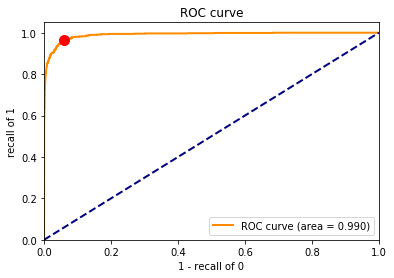

optimal threshold is 0.08722221106290817


In [72]:
t, _ = find_opti_thresh(y_train, proba[:,1])

Now, once the training is done, we predict the consolidation date for the test texts

In [73]:
candidates = []
sentence_dates = []
for i in tqdm(range(len(te_texts))):
    text = te_texts[i]
    index = []
    dates = []
    for k, pattern in enumerate(patterns):
        index.extend(re.finditer(pattern, text))
        dates.extend(re.findall(patterns_bis[k], text))

    zipped = sorted(list(zip(index,dates)), key = lambda x: x[0].start())
    for j in range((len(index))):
        index[j] = zipped[j][0]
        dates[j] = zipped[j][1]
    index = index[3:]
    dates = dates[3:]
    
    window = 100
    data = []
    s_d = []
    for k, ind in enumerate(index):
        day, month, year = dates[k][0], dates[k][1], dates[k][2]
        month = month.lower().replace('é', 'e').replace('û', 'u')
        if month in months_str_to_int:
            day, month, year = format_date(day, month, year)
            date = f"{year}-{month}-{day}"
            s_d.append(date)

            match1 = re.match(r"[^\.]*(\.)", text[ind.end(): ind.end() + window])        
            match2 = re.match(r"[^\.]*(\.)", text[ind.start() - window : ind.start()][::-1])
            if match2: start = len(text[:ind.start()]) - match2.end() + 1
            else: start = ind.start() - window
            if match1: end = len(text[:ind.end()]) + match1.end()
            else: end = ind.end() + window

            chunk = text[start:end]
            if start == ind.start() - window: chunk = re.sub(r"^[^\s]*\s*", "", chunk)
            if end == ind.end() + window: chunk = re.sub(r"\s*[^\s]*$", "", chunk)

            data.append(chunk)

    candidates.append(data)
    sentence_dates.append(s_d)

100%|██████████| 257/257 [00:01<00:00, 194.81it/s]


In [74]:
test_sentences_df = pd.DataFrame(columns=['te_idx', 'sentence', 'date'])
for i in tqdm(range(len(candidates))):
    test_sentences_df = pd.concat([test_sentences_df, 
                            pd.DataFrame({'te_idx': [i]*len(candidates[i]), 'sentence': candidates[i], 'date': sentence_dates[i]})],
                            ignore_index=True)

100%|██████████| 257/257 [00:00<00:00, 538.04it/s]


In [76]:
sentences_w_multip_dates_idx = list(test_sentences_df[test_sentences_df.duplicated('sentence')].index)
split_sentences_df = pd.DataFrame(columns=test_sentences_df.columns)

while sentences_w_multip_dates_idx != []:
    idx = sentences_w_multip_dates_idx[0]
    sentence = test_sentences_df.loc[idx, 'sentence']
    te_idx = test_sentences_df.loc[idx, 'te_idx']
    sentence_window = len(sentence) // 5
    sentences = {}

    for pattern_idx, pattern in enumerate(patterns):
        for date in re.finditer(pattern, sentence):
            current_date = date.group(0)
            reg_match = re.match(patterns_bis[pattern_idx], current_date)
            day, month, year = reg_match[1], reg_match[2], reg_match[3]
            try:
                day, month, year = format_date(day, month, year)
            except KeyError:
                continue            
            formated_date = f"{year}-{month}-{day}"
            sentences[formated_date] = sentence[max(date.start()-sentence_window, 0):date.end()+sentence_window]

    # drop current duplicated sentences from dataframe
    same_sentences_idx = test_sentences_df[(test_sentences_df['sentence']==sentence) & (test_sentences_df['te_idx']==te_idx)].index
    test_sentences_df.drop(same_sentences_idx, inplace=True)
    for idx in list(same_sentences_idx):
        if idx in sentences_w_multip_dates_idx:
            sentences_w_multip_dates_idx.remove(idx)
    split_sentences_df = pd.concat([split_sentences_df, 
            pd.DataFrame({'te_idx': [te_idx]*len(list(sentences.values())), 'sentence': list(sentences.values()), 'date': list(sentences.keys())})],
            ignore_index=True)

test_sentences_df = pd.concat([test_sentences_df, split_sentences_df], ignore_index=True)

In [77]:
candidates = []
sentence_dates = []

for i in tqdm(range(len(te_texts))):
    candidates.append(list(test_sentences_df.loc[test_sentences_df['te_idx']==i, 'sentence'].values))
    sentence_dates.append(list(test_sentences_df.loc[test_sentences_df['te_idx']==i, 'date'].values))

100%|██████████| 257/257 [00:00<00:00, 597.16it/s]


In [78]:
# clean texts
for i in tqdm(range(len(candidates))):
    candidates[i] = [clean2(candidate, lemmatizer, stemmer, stop_words = stop_words) for candidate in 
                        candidates[i]]

100%|██████████| 257/257 [00:08<00:00, 28.84it/s]


In [79]:
for i in range(len(candidates)):
    candidate = TF_IDF.transform(candidates[i])
    candidates[i] = candidate

In [80]:
na_x_test = na_vectorizer.transform([clean_text(text) for text in te_texts])
na_x_test_proba = xgb_cls_na.predict_proba(na_x_test)

In [82]:
na_positive_idx = np.where(xgb_cls_na.predict(na_x_test)==1)[0]

For the prediction, we first classify texts as containing an applicable cosolidation date or not.<br>
For the texts that are estimated to not include an applicable consolidation date, we predict their consolidation dates with the same procedure as for accident date

In [84]:
preds = []
for i, candidate in enumerate(candidates):
    if i in na_positive_idx:
        preds.append('n.a.')
        continue
    pred = np.argmax(classifier.predict_proba(candidate)[:,1])
    score = np.max(classifier.predict_proba(candidate)[:,1])
    if score < t: preds.append('n.c.')
    else:
        pred_date = sentence_dates[i][pred]
        preds.append(pred_date)

In [85]:
np.save('results/consolidation.npy', preds)

## Submission

Finally, we create the submission csv file using the saved numpy arrays for each of gender, accident date and conolidation date

In [111]:
gender = list(np.load('results/gender.npy'))
accident = list(np.load('results/accident.npy'))
consolidation = list(np.load('results/consolidation.npy'))

In [112]:
result = pd.read_csv('test_folder/x_test_ids.csv')

In [113]:
result['sexe'] = gender
result['date_accident'] = accident
result['date_consolidation'] = consolidation

In [114]:
result.index = result['ID']
result = result.drop('ID', axis = 1)
result

,filename,sexe,date_accident,date_consolidation
ID,,,,
770,Agen_1400036.txt,homme,2011-04-20,n.a.
771,Agen_20011399.txt,homme,1996-07-05,n.c.
772,Agen_21013.txt,homme,1989-05-11,n.c.
773,Agen_31076.txt,homme,1998-07-09,n.c.
774,Agen_3436.txt,homme,1999-05-28,2001-05-28
...,...,...,...,...
1022,Versailles_1102996.txt,homme,2005-04-07,n.a.
1023,Versailles_1404397.txt,femme,n.c.,1968-05-20
1024,Versailles_1508232.txt,femme,2014-08-07,2012-01-26


In [116]:
result.to_csv('results/result.csv')